In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recommendationsv4/sample_submission.csv
/kaggle/input/recommendationsv4/train.csv
/kaggle/input/recommendationsv4/test.csv
/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json
/kaggle/input/reviewpol/reviewPol.csv


In [2]:
RANDOM_SEED = 42           # зафиксируем начальные условия для генератора псевдослучайных чисел
!pip freeze > requirements # позволяет создать текстовый документ в котором перечислены 
                           #все установленные и необходимые для работы Python приложения программные пакеты
import json
import matplotlib.pyplot as plt
# нужно включать если код в ноутбуке
%matplotlib inline  
import seaborn as sns

In [3]:
# Загружаем данные
train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv')
test = pd.read_csv('/kaggle/input/recommendationsv4/test.csv')
submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# выгрузим json в датасет "meta"
with open('/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json') as f:
    meta_list = []
    for line in f.readlines():
        meta_list.append(json.loads(line))

meta = pd.DataFrame(meta_list)

In [5]:
#ресурсоемкая операция, сохраним результат
meta.to_csv('meta.csv', index=False)
meta = pd.read_csv('./meta.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
meta.info()
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      287209 non-null  object
 1   description   251802 non-null  object
 2   title         287205 non-null  object
 3   brand         275766 non-null  object
 4   rank          275494 non-null  object
 5   also_view     121012 non-null  object
 6   main_cat      285716 non-null  object
 7   price         132136 non-null  object
 8   asin          287209 non-null  object
 9   also_buy      83332 non-null   object
 10  image         150214 non-null  object
 11  date          9663 non-null    object
 12  feature       16374 non-null   object
 13  details       273323 non-null  object
 14  similar_item  256 non-null     object
 15  tech1         744 non-null     object
 16  fit           4 non-null       object
dtypes: object(17)
memory usage: 37.3+ MB
<class 'pandas.core.frame.Data

In [7]:
#посмотрим наличие дупликатов
print(train.duplicated().sum())
print(test.duplicated().sum())

28960
0


In [8]:
#удалим дуаликаты
train.drop_duplicates(inplace = True)

In [9]:
# добавим информацию из meta_Grocery_and_Gourmet_Food.json
data = pd.merge(train, meta, on='asin')
datatest = pd.merge(test , meta, on='asin')   #285965

In [10]:
m = meta[meta['asin'].isin(test['asin'])]

In [11]:
m.drop_duplicates(inplace = True)
datatest = pd.merge(test , m, on='asin')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
print(m.duplicated().sum())
del m
del meta

0


In [13]:
data.info()
datatest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         847593 non-null  float64
 1   verified        847593 non-null  bool   
 2   reviewTime      847593 non-null  object 
 3   asin            847593 non-null  object 
 4   reviewerName    847425 non-null  object 
 5   reviewText      847315 non-null  object 
 6   summary         847426 non-null  object 
 7   unixReviewTime  847593 non-null  int64  
 8   vote            118861 non-null  object 
 9   style           440351 non-null  object 
 10  image_x         7138 non-null    object 
 11  userid          847593 non-null  int64  
 12  itemid          847593 non-null  int64  
 13  rating          847593 non-null  float64
 14  category        847593 non-null  object 
 15  description     776098 non-null  object 
 16  title           847593 non-null  object 
 17  brand     

Таблицы отличаются:
в train есть дополнительные столбцы:
присутствует overall - оценка по пятибальной шкале
присутствует reviewText - текст отзыва
присутствует summary - краткое содержание отзыва
присутствует rating - целевая переманная

в test есть дополнительные столбец: Id


In [14]:
datatest = datatest.drop(['Id'], axis=1)

In [15]:
#отображение бохплойтов параметра относительно другого
def get_boxplot(x_column, y_column):
    fig, ax = plt.subplots(figsize = (12,2))
    sns.boxplot(x=x_column, y=y_column, 
                data=data.loc[data.loc[:, x_column].isin(data.loc[:, x_column].value_counts().index[:10])],
               ax=ax,orient = "h")
    plt.xticks(rotation=45)
    ax.set_title(x_column)
    plt.show() 

In [16]:
#rating  - целевая переменная
print(data.rating.isnull().sum()) #пропусков нет
print(data.rating.unique()) #признак является бинарным бинарный

0
[1. 0.]


<AxesSubplot:>

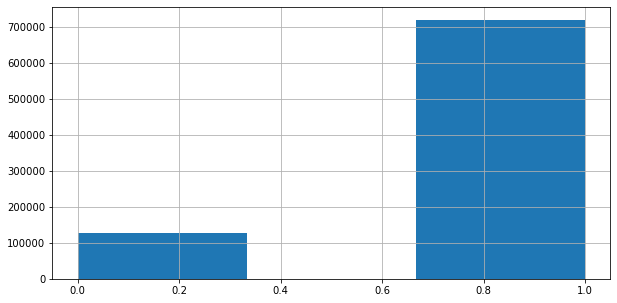

In [17]:
data.rating.hist(bins = 3, figsize = (10,5))
# признак не сбалансирован, положительных оценок значительно больше

In [18]:
#overall
print(data.overall.isnull().sum()) #пропусков нет
print(data.overall.unique()) #признак является ранжированым категориальным

0
[5. 3. 4. 1. 2.]


In [19]:
#приведем тип (int)
data['overall']=data['overall'].astype('int32')

<AxesSubplot:>

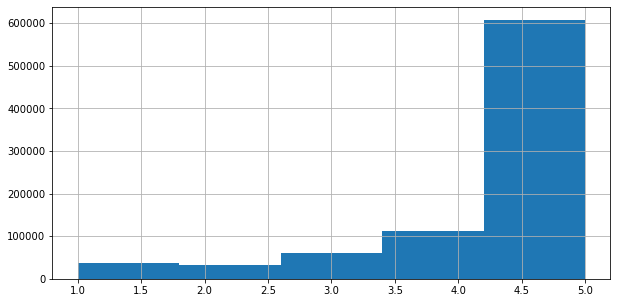

In [20]:
data.overall.hist(bins = 5, figsize = (10,5))

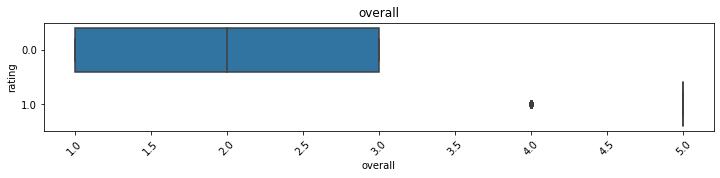

In [21]:
#Видна четкая зависимость с целевой переменной. 4 и более - положительный, менее 4 - отрицателный рейтинг.
#Будем использовать его для предварительной оценки других признаков.
get_boxplot('overall', 'rating')

In [22]:
#verified
print(data.verified.isnull().sum()) #пропусков нет
print(data.verified.unique()) #признак является бинарным

0
[ True False]


In [23]:
data.groupby('verified').mean()

,overall,unixReviewTime,userid,itemid,rating
verified,,,,,
False,4.186920,1.420655e+09,48891.468343,17792.469845,0.781918
True,4.479455,1.445126e+09,54490.862464,16984.016991,0.858841


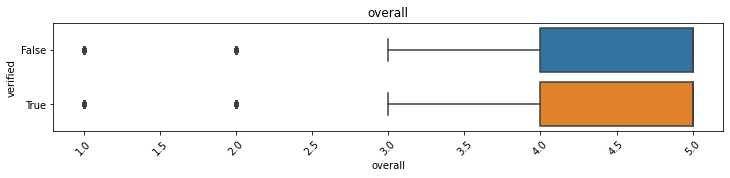

In [24]:
get_boxplot('overall','verified')
#явных зависимостей не видно. В целом у True средний рейтинг выше

In [25]:
#reviewTime
data.reviewTime.sample(4)

493336    05 26, 2016
741613    05 30, 2011
332953     04 7, 2013
754472    08 27, 2017
Name: reviewTime, dtype: object

In [26]:
#Столбец дублирует данныеи из unixReviewTime. удалим его
#data = data.drop(['reviewTime'], axis=1)

In [27]:
#datatest = datatest.drop(['reviewTime'], axis=1)

In [28]:
#reviewerName
print(data.reviewerName.isnull().sum()) #168 пропусков
print(data.reviewerName.unique()) #признак номенативный
print(data.reviewerName.value_counts()) 

168
['Heather' 'Tina McClain' 'Ella' ... 'Kristen keep' 'Alicia M' 'rivkaf']
Amazon Customer    31346
Kindle Customer     6128
Linda                729
John                 714
David                606
                   ...  
Aptos55                1
Gust H.                1
 SenoraMate            1
M. Wallace             1
Ghostlydreamer         1
Name: reviewerName, Length: 101207, dtype: int64


Большая часть отзывов от Amazon и Kindle. Разумно обьединить всех остальных вместе с пропусками в третью категорию other

In [29]:
print(datatest.reviewerName.isnull().sum()) 
print(datatest.reviewerName.unique()) 
print(datatest.reviewerName.value_counts()) 

47
['Rudys Mom' 'Asteroide 699' 'Tito in CR' ... 'Muxy Lady'
 'Tammy Knoll-Anderson' 'katydiscussions']
Amazon Customer    10642
Kindle Customer     2060
Linda                254
John                 225
Michael              195
                   ...  
Donald D. Head         1
Latcatin               1
OutdoorRED             1
T. J. CARTA            1
willycone              1
Name: reviewerName, Length: 86815, dtype: int64


In [30]:
data['reviewerName'] = data['reviewerName'].apply(lambda x: x if x!= 'Amazon Customer' else 'amazon')
data['reviewerName'] = data['reviewerName'].apply(lambda x: x if x!= 'Kindle Customer' else 'kindle')
data['reviewerName'] = data['reviewerName'].apply(lambda x: x if x== 'kindle' or x== 'amazon' else 'other')

In [31]:
datatest['reviewerName'] = datatest['reviewerName'].apply(lambda x: x if x!= 'Amazon Customer' else 'amazon')
datatest['reviewerName'] = datatest['reviewerName'].apply(lambda x: x if x!= 'Kindle Customer' else 'kindle')
datatest['reviewerName'] = datatest['reviewerName'].apply(lambda x: x if x== 'kindle' or x== 'amazon' else 'other')

In [32]:
print(data.reviewerName.value_counts()) 

other     810104
amazon     31358
kindle      6131
Name: reviewerName, dtype: int64


In [33]:
print(datatest.reviewerName.value_counts()) 

other     273260
amazon     10643
kindle      2062
Name: reviewerName, dtype: int64


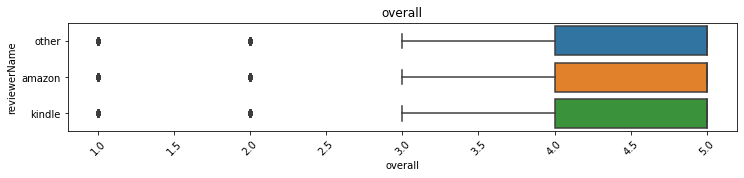

In [34]:
get_boxplot('overall','reviewerName')
#явных зависимостей не видно. Возможно признак можно удалить

In [35]:
#reviewText
print(data.reviewText.isnull().sum()) #278 пропусков #пропусков нет
print(data.reviewText.value_counts().head(15))
print(data.reviewText.value_counts()) # Большая часть отзывов одно двухсловное. Есть и развернутые отзывы.

278
good             3071
great            2600
Great            2054
Good             2016
ok               1306
Delicious        1093
Delicious!       1078
love it           986
Yummy             950
very good         921
Excellent         898
Great!            844
yummy             774
Great product     718
Love it           711
Name: reviewText, dtype: int64
good                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [36]:
#создадим признак с длинной отзыва в количестве слов.
data['reviewLen'] = data['reviewText'].apply( lambda x: len(str(x).split(' ')) )

In [37]:
#создадим признак показывающий полярность отзыва
#!pip install TextBlob

In [38]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
#text          = "I feel the product is so bad" 
# The polarity score is a float within the range [-1.0, 1.0]
# where negative value indicates negative text and positive
# value indicates that the given text is positive.
#sent          = TextBlob(text)
#polarity      = sent.sentiment.polarity

#print(polarity)

In [39]:
#data['reviewPol'] = data['reviewText'].apply(lambda x: TextBlob(str(x)).sentiment.polarity) 
#ресурсоемкая операция. Сохраним результат и будем подгружать.

In [40]:
#data['reviewPol'].to_csv('reviewPol.csv', index=False)
data['reviewPol'] = pd.read_csv('../input/reviewpol/reviewPol.csv')

In [41]:
#создадим списки хороших и плохих слов.
good = [
    "best",
    "good",
    "great",
    "love",
    "delicious",
    "nice",
    "enjoy",
    "loved",
    "tasty",
    "fantastic",
    "perfectly",
    "wow",
    "yummy",
    "happy",
    "loves",
    "lovely",
    "beautiful",
    "wonderful",
    "awesome",
    "perfect",
    "excellent",
    "yum",
    "enjoyed",
    "amazing",
    "favorite",
    "terrific",
    "enjoyable"
]

bad = [
    "awful",
    "bad",
    "difficult",
    "unfortunate",
    "waste",
    "complaint",
    "gross",
    "worst",
    "terrible",
    "horrible",
    "fake",
    "disappointing",
    "complaints",
    "poor",
    "disappointed",
    "strange",
    "weird",
    "sucks"
]



In [42]:
#функции для подсчета количества вхождений
def in_good(str):
    i = 0
    for word in good:
        i += str.count(word)
    return i
    
def in_bad(str):
    i = 0
    for word in bad:
        i += str.count(word)
    return i
    

In [43]:
#Создадим признаки показывающие количество хороших и плохих в отзыве.
data['reviewGood'] = data['reviewText'].apply( lambda x: in_good(str(x)) ) #считаем количество хороших слов
data['reviewBad'] = data['reviewText'].apply( lambda x: in_bad(str(x)) ) #считаем количество плохих слов

In [44]:
#в отдельный признак вынесем количество восклицательных знаков в отзыве
data['reviewExc'] = data['reviewText'].apply( lambda x: str(x).count('!') )

In [45]:
#data = data.drop(['reviewText'], axis=1)

In [46]:
#summary
print(data.summary.value_counts())

Five Stars                             171328
Four Stars                              26597
Three Stars                             11913
One Star                                 5300
Two Stars                                4920
                                        ...  
The Best Tea I've Ever Had                  1
Love Ginger!                                1
San Francisco Bay Coffee Fog Chaser         1
Better than other decafs I've tried         1
great salt free lemon pepper                1
Name: summary, Length: 411451, dtype: int64


In [47]:
#краткое описание предыдущего признака. удалим его
#data = data.drop(['summary'], axis=1)

In [48]:
#asin
print(data.asin.isnull().sum()) #пропусков нет
print(data.asin.value_counts()) #41302 позиции в магазине

0
B00BUKL666    5430
B00D3M2QP4    4733
B008QMX2SG    4611
B0001LO3FG    4252
B00R7PWK7W    2449
              ... 
B00BB1DPOA       1
B013795W94       1
B0015ICUUE       1
B0018S09T0       1
B0012QDZBM       1
Name: asin, Length: 41302, dtype: int64


In [49]:
print(datatest.asin.isnull().sum()) #пропусков нет
print(datatest.asin.value_counts()) 

0
B00BUKL666    1896
B008QMX2SG    1574
B00D3M2QP4    1488
B00R7PWK7W     840
B0001LO3FG     796
              ... 
B00GW9ARY2       1
B008Z99U68       1
B00PM22J7S       1
B00R3NMY42       1
B008OZ424S       1
Name: asin, Length: 37876, dtype: int64


In [50]:
#unixReviewTime
print(data.unixReviewTime.isnull().sum()) #пропусков нет
print(data.unixReviewTime.value_counts()) #
print(datatest.unixReviewTime.isnull().sum()) #пропусков нет
print(datatest.unixReviewTime.value_counts()) #

0
1456790400    941
1468454400    873
1433289600    783
1453248000    783
1455926400    767
             ... 
1144972800      1
1114041600      1
1190419200      1
1161734400      1
1185408000      1
Name: unixReviewTime, Length: 4580, dtype: int64
0
1456790400    316
1453248000    301
1433289600    278
1468454400    271
1430265600    265
             ... 
1187654400      1
1177459200      1
1179187200      1
1179878400      1
1167696000      1
Name: unixReviewTime, Length: 4349, dtype: int64


<AxesSubplot:>

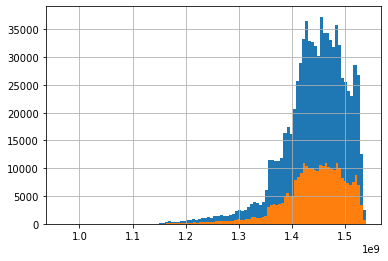

In [51]:
data.unixReviewTime.hist(bins=100)
datatest.unixReviewTime.hist(bins=100)
#растпределения в траине и тесте похожи.

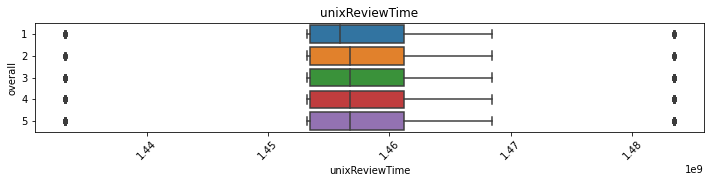

In [52]:
get_boxplot('unixReviewTime', 'overall') #распределение оценок по времени одинаковое. явных зависимостей нет

In [53]:
from datetime import datetime

In [54]:
print('первый отзыв:', datetime.utcfromtimestamp(data.unixReviewTime.min()).strftime('%Y-%m-%d'))
print('последний отзыв:', datetime.utcfromtimestamp(data.unixReviewTime.max()).strftime('%Y-%m-%d'))

первый отзыв: 2000-08-09
последний отзыв: 2018-10-02


In [55]:
datetime.utcfromtimestamp(data.unixReviewTime.min())

datetime.datetime(2000, 8, 9, 0, 0)

In [56]:
#datetime.fromtimestamp(data.unixReviewTime.min()).weekday()

In [57]:
#создадим признаки соответвующие месяцу и дню недели отзыва
data['reviewMonth'] = data['unixReviewTime'].apply( lambda x:  datetime.fromtimestamp(x).month ) 
datatest['reviewMonth'] = datatest['unixReviewTime'].apply( lambda x:  datetime.fromtimestamp(x).month ) 

In [58]:
data['reviewWeekday'] = data['unixReviewTime'].apply( lambda x:  datetime.fromtimestamp(x).weekday() ) 
datatest['reviewWeekday'] = datatest['unixReviewTime'].apply( lambda x:  datetime.fromtimestamp(x).weekday() ) 

<AxesSubplot:>

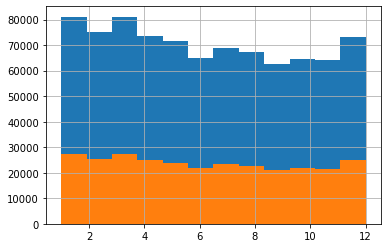

In [59]:
#посмотрм на новые признаки
data.reviewMonth.hist(bins=12) #по месяцам распределение достаточно равномерное, больше покупок в начале года и перед новым годом
datatest.reviewMonth.hist(bins=12)

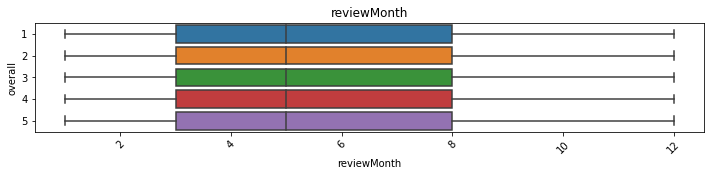

In [60]:
get_boxplot('reviewMonth', 'overall') #явной зависимости оценки от месяца нет

<AxesSubplot:>

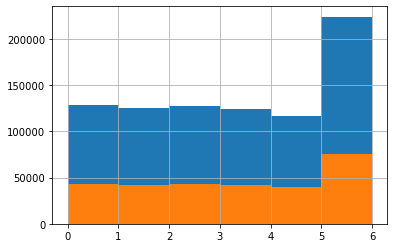

In [61]:
data.reviewWeekday.hist(bins=6) #в воскресенье покупок примерно в 2 раза больше чем в другие дни
datatest.reviewWeekday.hist(bins=6)

In [62]:
data['reviewDay'] = data['unixReviewTime'].apply( lambda x:  datetime.fromtimestamp(x).day ) 
datatest['reviewDay'] = datatest['unixReviewTime'].apply( lambda x:  datetime.fromtimestamp(x).day ) 

<AxesSubplot:>

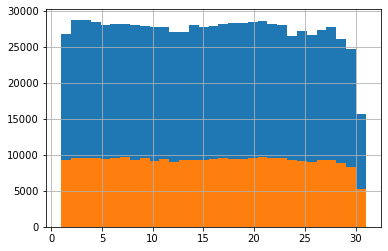

In [63]:
data.reviewDay.hist(bins=31) #в течении месяца распределение равномерное
datatest.reviewDay.hist(bins=31)

In [64]:
#vote
print(data.vote.isnull().sum()) #728732 пропусков
print(data.vote.value_counts()) #477 различных вариантов  
print(datatest.vote.isnull().sum()) #251736пропусков
print(datatest.vote.value_counts()) #304 различных вариантов

728732
2.0      30774
3.0      15336
2        13786
4.0       8893
3         6969
         ...  
363.0        1
360.0        1
359.0        1
159          1
392          1
Name: vote, Length: 477, dtype: int64
246503
2.0      7959
2        6846
3.0      3986
3        3418
4.0      2224
         ... 
186         1
96          1
80          1
127.0       1
531.0       1
Name: vote, Length: 304, dtype: int64


In [65]:
#похоже что эквивалент количества лайков поставленых отзыву. Тогда пропуски можно заменить на 0
data.vote = data.vote.fillna(0)
datatest.vote = datatest.vote.fillna(0)

<AxesSubplot:>

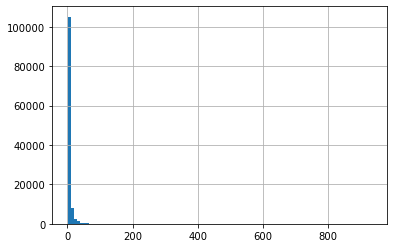

In [66]:
#приведем все записи к int
data['vote'] = data['vote'].astype('str')
data['vote'] = data['vote'].apply( lambda x:  x.split('.')[0]) 
data['vote'] = data['vote'].apply( lambda x:  x.split(',')[0]) 
data['vote'] =  data['vote'].astype('int') 
data['vote'][data['vote'] > 0].hist(bins = 100)

<AxesSubplot:>

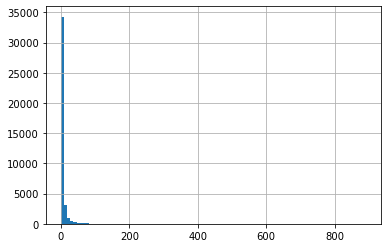

In [67]:
datatest['vote'] = datatest['vote'].astype('str')
datatest['vote'] = datatest['vote'].apply( lambda x:  x.split('.')[0]) 
datatest['vote'] = datatest['vote'].apply( lambda x:  x.split(',')[0]) 
datatest['vote'] =  datatest['vote'].astype('int') 
datatest['vote'][datatest['vote'] > 0].hist(bins = 100)

In [68]:
#огромное количество нулей. логарифмирование ситуацию не исправляет

In [69]:
#Сделаем признак категориальным.
#def cat_vote(x):
#    if x == 'low' or x == 'middle' or x == 'high' : x = x
#    elif x < 3: x = 'low'
#    elif 3 <= x <= 100: x = 'middle'
#    elif 100 < x: x = 'high'
#    return x      


#data['vote'] = data['vote'].apply(lambda x: cat_vote(x))

In [70]:
#datatest['vote'] = datatest['vote'].apply(lambda x: cat_vote(x))

In [71]:
data['vote'].value_counts()

0      728732
2       44560
3       22305
4       12872
5        8275
        ...  
223         1
221         1
220         1
218         1
507         1
Name: vote, Length: 308, dtype: int64

In [72]:
datatest['vote'].value_counts()

0      246503
2       14808
3        7404
4        4128
5        2719
        ...  
123         1
302         1
119         1
118         1
254         1
Name: vote, Length: 196, dtype: int64

In [73]:
#style
print(data['style'].isnull().sum()) #407242 пропусков
print(data['style'].value_counts()) #25892 различных стиля

407242
{'Size:': ' Pack of 1'}                                                      4856
{'Package Quantity:': ' 1'}                                                  4526
{'Package Type:': ' Standard Packaging'}                                     3898
{'Size:': ' 1 Pack'}                                                         3848
{'Size:': ' 24 Count'}                                                       3640
                                                                             ... 
{'Flavor:': ' Medium Pineapple'}                                                1
{'Size:': ' 4-Ounce Bags (Pack of 15)', 'Flavor:': ' Aged White Cheddar'}       1
{'Size:': ' 14-Ounce Bags (Pack of 4)', 'Flavor:': ' Iced Oatmeal'}             1
{'Size:': ' 26 Pound (Pack of 24)'}                                             1
{'Flavor:': ' Basil Chili Rice'}                                                1
Name: style, Length: 25892, dtype: int64


In [74]:
#пока удалим признак
#data = data.drop(['style'], axis=1)

In [75]:
#datatest = datatest.drop(['style'], axis=1)

In [76]:
#image_x
print(data['image_x'].isnull().sum()) 
print(data['image_x'].value_counts()) 
print(datatest['image_x'].isnull().sum()) 
print(datatest['image_x'].value_counts())

840455
['https://images-na.ssl-images-amazon.com/images/I/712zJIOTV5L._SY88.jpg']                                                                                                                                                                                                                                                                                                                                                                                      6
['https://images-na.ssl-images-amazon.com/images/I/71+Z1TA3eyL._SY88.jpg']                                                                                                                                                                                                                                                                                                                                                                                      6
['https://images-na.ssl-images-amazon.com/images/I/81h8Zc+1rzL._SY88.jpg']                   

In [77]:
#можно сделать признак указывающий на наличие или отсутсвие картинки к товару
#data['image_x'] = data['image_x'].isnull()
#datatest['image_x'] = datatest['image_x'].isnull()

In [78]:
print(data['image_x'].value_counts()) # картинок почти нет
print(datatest['image_x'].value_counts())

['https://images-na.ssl-images-amazon.com/images/I/712zJIOTV5L._SY88.jpg']                                                                                                                                                                                                                                                                                                                                                                                      6
['https://images-na.ssl-images-amazon.com/images/I/71+Z1TA3eyL._SY88.jpg']                                                                                                                                                                                                                                                                                                                                                                                      6
['https://images-na.ssl-images-amazon.com/images/I/81h8Zc+1rzL._SY88.jpg']                          

In [79]:
#userid
print(data['userid'].isnull().sum()) #пропусков нет
print(datatest['userid'].isnull().sum()) #пропусков нет

0
0


In [80]:
#itemid
print(data['itemid'].isnull().sum()) #пропусков нет
print(datatest['itemid'].isnull().sum()) #пропусков нет

0
0


In [81]:
#category
print(data['category'].isnull().sum()) 
print(data['category'].value_counts()) 
print(datatest['category'].isnull().sum()) 
print(datatest['category'].value_counts()) 

0
['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Coffee', 'Single-Serve Capsules & Pods']     54966
['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']                               20301
['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']                                                15472
['Grocery & Gourmet Food', 'Candy & Chocolate', 'Candy & Chocolate Bars']                                    15198
['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Coffee', 'Roasted Coffee Beans']             14367
                                                                                                             ...  
['Grocery & Gourmet Food', 'Sauces, Gravies & Marinades', 'Sauces', 'Spanish & Mexican', 'Sofrito Sauce']        3
['Grocery & Gourmet Food', 'Produce', 'Fresh Vegetables', 'Peppers']                                             3
['Grocery & Gourmet Food', 'Produce', 'Fresh Vegetables', 'Tomatillos']       

In [82]:
df = data['category'].apply( lambda x: str(x).split(', ') )

In [83]:
#удалим лишние символы
def delbad(list):
    out_list = []
    for item in list:
        i =  str(item).replace('[', '')
        i =  i.replace(']', '')
        i =  i.replace('\"', '')
        i =  i.replace('\'', '')
        out_list.append(i)
    return out_list
        


In [84]:
df = df.apply( lambda x: delbad(x) )
data['category'] = df

In [85]:
df = datatest['category'].apply( lambda x: str(x).split(', ') )
df = df.apply( lambda x: delbad(x) )
datatest['category'] = df

In [86]:
#найдем самые популярные категории только по трейну
top = 25
all_categories = []

#заполняем список
for category in data.category:
    all_categories.extend(category)

# Считаем частоту категорий в датасете
from collections import Counter
cnt = Counter()
for word in all_categories:
    cnt[word] +=1
    
#Оставим топ категорий
top_cat = []
for i in range (0, len(cnt.most_common(top))):
    cat = cnt.most_common(top)[i][0]
    top_cat.append(cat)
    
# Удаляем дубликаты из all_categories
all_categories = list(dict.fromkeys(all_categories))

print('Всего категорий: ', len(all_categories))
print('Топ', top, 'категорий: ',top_cat)

Всего категорий:  1053
Топ 25 категорий:  ['Grocery & Gourmet Food', 'Coffee', 'Beverages', 'Tea & Cocoa', 'Cooking & Baking', 'Snack Foods', 'Candy & Chocolate', 'Tea', 'Herbs', 'Spices & Seasonings', 'Single-Serve Capsules & Pods', 'Bottled Beverages', 'Water & Drink Mixes', 'Nuts & Seeds', 'Breakfast Foods', 'Canned', 'Jarred & Packaged Foods', 'Single Herbs & Spices', 'Sauces', 'Bars', 'Syrups', 'Sugars & Sweeteners', 'Green', 'Cooking Oils', 'Vinegars & Sprays']


In [87]:
# создадим признак показывающий на отношение к категории в топ 25
def topinc (list):
    i = 0
    for cat in list:
        if cat in top_cat:
            i +=1
    return i

In [88]:
data['categoryTop'] = data['category'].apply(lambda x: topinc(x))
datatest['categoryTop'] = datatest['category'].apply(lambda x: topinc(x))

In [89]:
print(data['categoryTop'].value_counts())
print(data['categoryTop'].value_counts())

2    299054
3    135768
4    125417
1    119247
5     92840
6     75267
Name: categoryTop, dtype: int64
2    299054
3    135768
4    125417
1    119247
5     92840
6     75267
Name: categoryTop, dtype: int64


In [90]:
#data = data.drop(['category'], axis = 1)
#datatest = datatest.drop(['category'], axis = 1)

<AxesSubplot:>

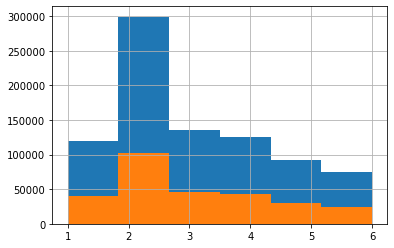

In [91]:
#посмотрим на новый признак
data.categoryTop.hist(bins=6) 
datatest.categoryTop.hist(bins=6) #распределения похожи

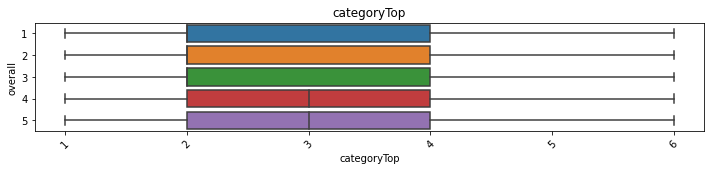

In [92]:
get_boxplot('categoryTop', 'overall') #явной зависимости оценки нет

In [93]:
#description
print(data['description'].isnull().sum()) 
print(datatest['description'].isnull().sum()) 

71495
23905


In [94]:
data['description'].sample(2)

114675    ['Its no accident that Lavazza is Italys favor...
313181    ['Kirkland Signature Premium Chocolates of the...
Name: description, dtype: object

In [95]:
#посже можно повыделять ключевые слова и сделать на их основе признаки как было сделано раанее с отзывами и категориями
#очень много пропусков. пока удалим
#data = data.drop(['description'], axis = 1)

In [96]:
#datatest = datatest.drop(['description'], axis = 1)

In [97]:
#title
print(data['title'].isnull().sum()) 
print(datatest['title'].isnull().sum()) 
data['title'].sample(2)

0
0


9004      Nutiva Organic, non-GMO, Premium Ground Chia S...
190467    7 Pepper Spice Mix (Nanami / Schichimi Togaras...
Name: title, dtype: object

In [98]:
#сделаем то же что с категориями
data['title'] = data['title'].apply( lambda x: x.split(', ') )

In [99]:
datatest['title'] = datatest['title'].apply( lambda x: x.split(', ') )

In [100]:
datatest['title'].sample(2)

82328     [2LB Pumpkin Seeds Roasted Salted, Pepitas Roa...
226808    [Hidden Springs Organic Vermont Maple Syrup, D...
Name: title, dtype: object

In [101]:
#найдем самые популярные категории
top = 25
all_titls = []

#заполняем список
for title in data.title:
    all_titls.extend(title[:1])
    


# Считаем частоту категорий в датасете
from collections import Counter
cnt2 = Counter()
for word in all_titls:
    cnt2[word] +=1
    
#Оставим топ категорий
top_title = []
for i in range (0, len(cnt2.most_common(top))):
    cat = cnt2.most_common(top)[i][0]
    top_title.append(cat)
    
# Удаляем дубликаты из all_categories
all_titls = list(dict.fromkeys(all_titls))

print('Всего категорий: ', len(all_titls))
print('Топ', top, 'категорий: ',top_title)

Всего категорий:  36773
Топ 25 категорий:  ['KIND Bars', 'Kind Bars', 'Twinings of London Pure Camomile Herbal Tea Bags', 'Nutiva Organic', 'YumEarth Organic Lollipops', 'Twinings of London English Afternoon Black Tea Bags', 'Celestial Seasonings Tension Tamer Tea', 'Keurig', 'Planters Peanuts', "Davidson's Tea Bulk", 'Planters Dry Roasted Peanuts', 'Green Mountain Coffee', 'SweetLeaf Sweet Drops Liquid Stevia Sweetener', 'Designer Whey Premium Natural 100% Whey Protein', 'Twinings of London Christmas Black Tea Bags', 'Planters Salted Peanuts', 'Caza Trail Coffee', 'Twinings of London English Breakfast Tea K-Cups for Keurig', 'Planters Flavored Peanuts', 'Haribo Gummi Candy', 'Kettle Brand Potato Chips', "Nature's Way Organic Extra Virgin Coconut Oil- Pure", 'Viva Naturals Organic Extra Virgin Coconut Oil', 'Healthworks Cacao Powder Organic', 'Grove Square Cappuccino']


In [102]:
# создадим признак показывающий на отношение к категории в топ 25
def toptit (list):
    i = 0
    for cat in list:
        if cat in top_title:
            i +=1
    return i

In [103]:
data['categoryTit'] = data['title'].apply(lambda x: toptit(x))
datatest['categoryTit'] = datatest['title'].apply(lambda x: toptit(x))

In [104]:
data['categoryTit'].unique()

array([0, 1, 2])

In [105]:
datatest['categoryTit'].unique()

array([0, 1, 2])

In [106]:
#data = data.drop(['title'], axis = 1)
#datatest = datatest.drop(['title'], axis = 1)

<AxesSubplot:>

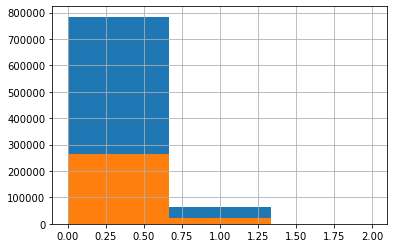

In [107]:
#посмотрим на новый признак
data.categoryTit.hist(bins=3) 
datatest.categoryTit.hist(bins=3) #распределения похожи

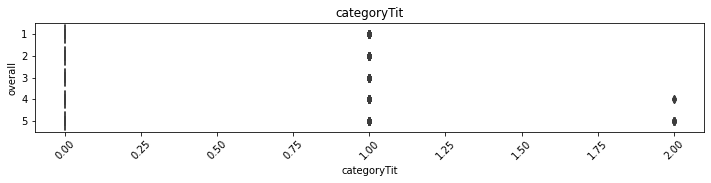

In [108]:
get_boxplot('categoryTit', 'overall') #большинство товаров не вошло ни в одну из популярных категорий, возможно нужно увеличить топ

In [109]:
#brand
print(data['brand'].isnull().sum()) 
print(datatest['brand'].isnull().sum()) 
data['brand'].value_counts().head(10)


6104
2108


KIND                              22506
Bob's Red Mill                    13061
Twinings                          11182
Planters                          10384
Frontier                           6926
Green Mountain Coffee Roasters     6791
Celestial Seasonings               6154
McCormick                          5319
Kirkland Signature                 5304
Healthworks                        5046
Name: brand, dtype: int64

In [110]:
#заменим пропуски на others
data.brand = data.brand.fillna('others')
datatest.brand = datatest.brand.fillna('others')

In [111]:
#позже можно будет применить target encoding. либо оставить 10 наиболе популярных значений и сделать dummy перпе

In [112]:
#data = data.drop(['brand'], axis = 1)
#datatest = datatest.drop(['brand'], axis = 1)

In [113]:
#rank
print(data['rank'].isnull().sum()) 
print(datatest['rank'].isnull().sum()) 
print(data['rank'].value_counts())

34598
12359
18inGroceryGourmetFood(                                                                                                                                                                                    7421
4,575inGroceryGourmetFood(                                                                                                                                                                                 4733
2,949inGroceryGourmetFood(                                                                                                                                                                                 4611
142,261inGroceryGourmetFood(                                                                                                                                                                               4252
72inGroceryGourmetFood(                                                                                                                                     

In [114]:
# Приведем к числовому виду
import re
data['rank'] = data['rank'].astype('str')
datatest['rank'] = datatest['rank'].astype('str')
# Удалим все значения кроме числовых
data['rank'] = data['rank'].apply(lambda x: re.sub('\D', '', x))
datatest['rank'] = datatest['rank'].apply(lambda x: re.sub('\D', '', x))
# Заменим пропуски на высокий ранг (предположим, что чем ниже ранг, тем лучше)
data['rank'] = data['rank'].apply(lambda x: 99999 if x == '' else x)
data['rank'] = data['rank'].astype('float')
datatest['rank'] = datatest['rank'].apply(lambda x: 99999 if x == '' else x)
datatest['rank'] = datatest['rank'].astype('float')
# Остаются какие-то большие значения, заменим их на высокий ранг
data['rank'] = data['rank'].apply(lambda x: 99999 if x > 99999 else x)
data['rank'] = data['rank'].astype('int32')
datatest['rank'] = datatest['rank'].apply(lambda x: 99999 if x > 99999 else x)
datatest['rank'] = datatest['rank'].astype('int32')



In [115]:
data['rank'].sample(3)
datatest['rank'].sample(3)

258605    99999
137347    18560
2747         18
Name: rank, dtype: int32

<AxesSubplot:>

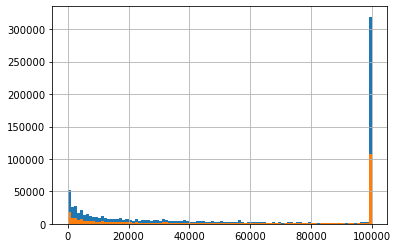

In [116]:
#посмотрим на новый признак
data['rank'].hist(bins=100) 
datatest['rank'].hist(bins=100) #распределения похожи

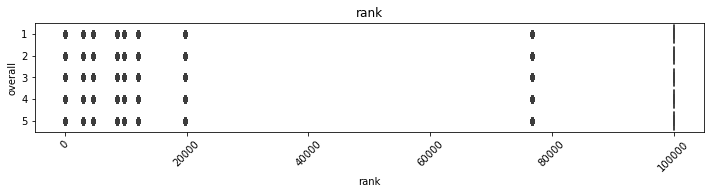

In [117]:
get_boxplot('rank', 'overall') 

In [118]:
# Создадим 3 категории рангов
#def cat_rank(x):
#    if x < 1093: x = 'high'
#    elif 1093 <= x <= 18000: x = 'middle'
#    elif 18000 < x: x = 'low'
#    return x      

# Заменим значения в столбце на категории
#data['rank'] = data['rank'].apply(lambda x: cat_rank(x))

In [119]:
#also_view
print(data['also_view'].isnull().sum()) 
print(datatest['also_view'].isnull().sum()) 
data['also_view'].sample(5)

384222
129409


611428                                                  NaN
65616                                                   NaN
120964    ['B005VBD2UI', 'B009LJO3QI', 'B000WLAW8C', 'B0...
597085                                                  NaN
492917    ['B0153HFZBS', 'B003D0WM8W', 'B00MOGQ5GG', 'B0...
Name: also_view, dtype: object

In [120]:
#пока удалим 
#data = data.drop(['also_view'], axis = 1)
#datatest = datatest.drop(['also_view'], axis = 1)

In [121]:
#main_cat
print(data['main_cat'].isnull().sum()) 
print(datatest['main_cat'].isnull().sum()) 
print(data['main_cat'].value_counts())

955
334
Grocery                      802613
Health & Personal Care        31705
Amazon Home                    7383
All Beauty                     1522
Sports & Outdoors              1322
Industrial & Scientific         902
Office Products                 631
Toys & Games                    304
Pet Supplies                    125
Tools & Home Improvement         53
Baby                             34
Arts, Crafts & Sewing            19
Home Audio & Theater              9
Camera & Photo                    8
Software                          3
Musical Instruments               3
Cell Phones & Accessories         2
Name: main_cat, dtype: int64


In [122]:
# Заменим пропуски на оther
data.main_cat = data.main_cat.fillna('other')
datatest.main_cat = datatest.main_cat.fillna('other')

In [123]:
#price
print(data['price'].isnull().sum()) 
print(datatest['price'].isnull().sum()) 
data['price'].sample(5)

258621
87115


390541     $5.75
602720    $32.90
195155    $23.38
63827     $14.79
377715       NaN
Name: price, dtype: object

In [124]:
#приведем к float, заменим диападоны цен средним в диапазоне, пропуски - средним по датасету
data1 = data['price'].apply(lambda x: str(x).replace('$','') )
data2 = datatest['price'].apply(lambda x: str(x).replace('$','') )

In [125]:
data1 = data1.apply( lambda x: x.split(' - ') )
data2 = data2.apply( lambda x: x.split(' - ') )

In [126]:
data1 = data1.apply( lambda x: float(x[0]) if len(x) == 1 else (float(x[0])+float(x[1]))/2  )
data2 = data2.apply( lambda x: float(x[0]) if len(x) == 1 else (float(x[0])+float(x[1]))/2  )

In [127]:
data1 = data1.fillna(data1.mean())
data2 = data1.fillna(data1.mean()) # в тесте заполняем пропуски средним посчитанном в трайне

In [128]:
data['price'] = data1
datatest['price'] = data2

In [129]:
del data1
del data2

<AxesSubplot:>

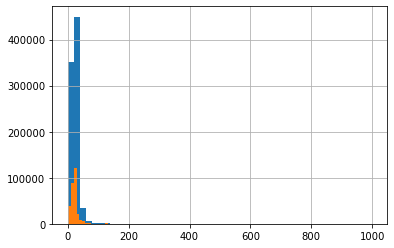

In [130]:
data['price'].hist(bins=50) 
datatest['price'].hist(bins=50) #распределения похожи

<AxesSubplot:>

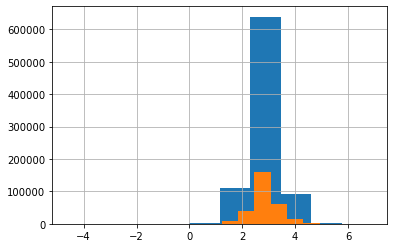

In [131]:
data1 = data['price'].apply(lambda x: np.log(x)) # возможно есть смысл прологарифмировать параметр
data2 = datatest['price'].apply(lambda x: np.log(x))
data1.hist()
data2.hist()

In [132]:
data['price'] = data1 
datatest['price'] = data2

In [133]:
del data1 
del data2

In [134]:
#also_buy
print(data['also_buy'].isnull().sum()) 
print(datatest['also_buy'].isnull().sum()) 
data['also_buy'].sample(5)

120735
40603


469916                                                  NaN
367061    ['B004LKVRLG', 'B0001M0Z6Q', 'B01FT7T8XS', 'B0...
661079    ['B00IE72K04', 'B00IE6Y6J8', 'B0009WC4G2', 'B0...
193324    ['B0103BQ860', 'B015ELD8RG', 'B0737DR48C', 'B0...
465248    ['B000U94MN2', 'B0032123XQ', 'B00TP55KME', 'B0...
Name: also_buy, dtype: object

In [135]:
#пока удалим
#data = data.drop(['also_buy'], axis = 1)
#datatest = datatest.drop(['also_buy'], axis = 1)

In [136]:
#image_y
print(data['image_y'].isnull().sum()) 
print(datatest['image_y'].isnull().sum()) 
data['image_y'].sample(5)

92239
30838


284825    ['https://images-na.ssl-images-amazon.com/imag...
552852    ['https://images-na.ssl-images-amazon.com/imag...
23149     ['https://images-na.ssl-images-amazon.com/imag...
298572    ['https://images-na.ssl-images-amazon.com/imag...
636768    ['https://images-na.ssl-images-amazon.com/imag...
Name: image_y, dtype: object

In [137]:
#сделаем как в прошлый раз
#data['image_y'] = data['image_y'].isnull()
#datatest['image_y'] = datatest['image_y'].isnull()


In [138]:
print(data['image_y'].value_counts())
print(datatest['image_y'].value_counts())

['https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51v5Q6bn3UL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/518%2Blf82NkL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61eyWeV4LML._SS40_.jpg']                                                                                                              7421
['https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51fuf1WpaaL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61EOMWLldQL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41lxe%2B2Vv1L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51wZrUhWnDL._SS40_PKmb-play-button-overlay-thumb_.jpg']    4733
['https://images

In [139]:
#get_boxplot('image_y', 'overall') # явных зависимостей нет

In [140]:
#date
print(data['date'].isnull().sum()) 
print(datatest['date'].isnull().sum()) 
datatest['date'].sample(2)

835506
281884


216804    NaN
182599    NaN
Name: date, dtype: object

In [141]:
#очень много пропусков, сделаем как с картинками
#data['date'] = data['date'].isnull()
#datatest['date'] = datatest['date'].isnull()

In [142]:
#feature
print(data['feature'].isnull().sum()) 
print(datatest['feature'].isnull().sum()) 
data['feature'].sample(5)

704859
237463


311355                                                  NaN
732258                                                  NaN
46155     ['Delicious Barilla pasta the whole family wil...
670224                                                  NaN
701186                                                  NaN
Name: feature, dtype: object

In [143]:
#очень много пропусков, поступим так же
#data['feature'] = data['feature'].isnull()
#datatest['feature'] = datatest['feature'].isnull()

In [144]:
#details
print(data['details'].isnull().sum())
print(datatest['details'].isnull().sum())
data['details'].sample(5)

14608
4880


738015    \n\n\n\n\n\n    <div class="disclaim">Size: <s...
400676    \n\n\n\n\n\n    <div class="disclaim">Size: <s...
525690    \n\n\n\n\n\n    <div class="disclaim">Size: <s...
164734    \n\n\n\n\n\n    <div class="disclaim">Flavor: ...
84333     \n\n\n\n\n\n    <div class="disclaim">Flavor: ...
Name: details, dtype: object

In [145]:
#пока удалим
#data = data.drop(['details'], axis = 1)
#datatest = datatest.drop(['details'], axis = 1)

In [146]:
#similar_item
print(data['similar_item'].isnull().sum()) 
print(datatest['similar_item'].isnull().sum()) 
data['similar_item'].sample(5)

846455
285523


630227    NaN
206275    NaN
788523    NaN
428376    NaN
303504    NaN
Name: similar_item, dtype: object

In [147]:
#очень много пропусков
#data['similar_item'] = data['similar_item'].isnull()
#datatest['similar_item'] = datatest['similar_item'].isnull()

In [148]:
#tech1
print(data['tech1'].isnull().sum()) 
print(datatest['tech1'].isnull().sum()) 
len(datatest['tech1'].unique())

843221
284539


82

In [149]:
#очень много пропусков
#data['tech1'] = data['tech1'].isnull()
#datatest['tech1'] = datatest['tech1'].isnull()

In [150]:
#fit
print(data['fit'].isnull().sum()) 
print(datatest['fit'].isnull().sum()) 
data['fit'].unique()

847593
285965


array([nan], dtype=object)

In [151]:
#пустой удалим
#data = data.drop(['fit'], axis = 1)
#datatest = datatest.drop(['fit'], axis = 1)

In [152]:
#в тесте нет параметра reviewText поэтому пока удалим все что с ним связано, а так же удалим owerall
data = data.drop(['overall', 'reviewExc', 'reviewBad', 'reviewGood', 'reviewPol', 'reviewLen'], axis = 1)

In [153]:
data.info()
datatest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 34 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   verified        847593 non-null  bool   
 1   reviewTime      847593 non-null  object 
 2   asin            847593 non-null  object 
 3   reviewerName    847593 non-null  object 
 4   reviewText      847315 non-null  object 
 5   summary         847426 non-null  object 
 6   unixReviewTime  847593 non-null  int64  
 7   vote            847593 non-null  int64  
 8   style           440351 non-null  object 
 9   image_x         7138 non-null    object 
 10  userid          847593 non-null  int64  
 11  itemid          847593 non-null  int64  
 12  rating          847593 non-null  float64
 13  category        847593 non-null  object 
 14  description     776098 non-null  object 
 15  title           847593 non-null  object 
 16  brand           847593 non-null  object 
 17  rank      

In [154]:
import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split
from lightfm.evaluation import auc_score
import scipy.sparse as sparse

In [155]:
#train_data, test_data = train_test_split(train,random_state=32, shuffle=True)
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

Чтобы работать с моделями в библиотеке LightFm, нам нужно создать разреженные матрицы. Мы будем хранить данные в формате COO (координатный формат представления данных). Вместо хранения всех значений, которые включают нулевые значения, мы будем хранить только ненулевые значения. В COO данные представлены в виде (строка, столбец, значение).

In [156]:
ratings_coo = sparse.coo_matrix((train['rating'].astype(int),
                                 (train['userid'],
                                  train['itemid'],)))

In [157]:
#подберем гиперпараметры

*      Разделите свои данные на обучающий набор, набор проверки и набор тестов.
*     Определите распределение для каждого гиперпараметра, который вы хотели бы оптимизировать. Например, если вы оптимизируете свою скорость обучения, вы можете использовать экспоненциальное распределение со средним значением 0,05; если вы оптимизируете функцию потерь, вы можете выборочно выбирать из ['warp', 'bpr', 'warp-kos'].
*     На каждой итерации оптимизации проведите все ваши гиперпараметры и используйте их, чтобы они соответствовали модели данных обучения. Оцените производительность модели в наборе валидации.
*     После выполнения нескольких шагов оптимизации выберите тот, который имеет лучшую эффективность проверки.

Чтобы оценить производительность конечной модели, вы должны использовать тестовый набор: просто оцените лучшую модель проверки на тестовом наборе.

In [158]:
import itertools

import numpy as np

from lightfm import LightFM
from lightfm.evaluation import auc_score


def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """

    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }


def random_search(train, test, num_samples=10, num_threads=1):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.

    Parameters
    ----------

    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.

    Returns
    -------

    generator of (auc_score, hyperparameter dict, fitted model)

    """

    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train, epochs=num_epochs, num_threads=num_threads)
        
        preds = model.predict(test_data.userid.values, test_data.itemid.values)
        
        score = sklearn.metrics.roc_auc_score(test_data.rating, preds)
        

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)

In [159]:
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

In [160]:
ratings_coo_tr = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'],)))
ratings_coo_te = sparse.coo_matrix((test_data['rating'].astype(int),
                                 (test_data['userid'],
                                  test_data['itemid'],)))

In [161]:
from lightfm.datasets import fetch_movielens

(score, hyperparams, model) = max(random_search(ratings_coo_tr, ratings_coo_te, num_threads=2), key=lambda x: x[0])

print("Best score {} at {}".format(score, hyperparams))

Best score 0.584886990644964 at {'no_components': 60, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.07346552487784631, 'item_alpha': 4.454804657075649e-08, 'user_alpha': 1.104690527030134e-08, 'max_sampled': 13, 'num_epochs': 10}


In [162]:
#результаты не впечатляющие, но запускать огромное количество итераций на рандомном поиске нет ресурсов.
#Оставим существующие праметры

In [163]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [164]:
#oбучим модель
LR = 0.0132349
NUM_THREADS = 12 #число потоков
NUM_COMPONENTS = 160 #число параметров вектора 
NUM_EPOCHS = 25 #число эпох обучения
LEARNING_SCHEDULE = 'adagrad'
LOSS_FUNCTION = 'logistic'
RANDOM_STATE = 20

In [165]:
space ={'no_components': hp.quniform('x_no_components', 40, 160, 20),
        'learning_rate': hp.uniform ('x_learning_rate', 0.01, 0.1)
    }

In [166]:
def objective(space):
    
    model = LightFM(      #создаем модель
    learning_rate=space['learning_rate'],
    loss=LOSS_FUNCTION,
    no_components=space['no_components'],
    learning_schedule = LEARNING_SCHEDULE,
    random_state = RANDOM_STATE
                    )
    
    model = LightFM(      #создаем модель
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    no_components=NUM_COMPONENTS,
    learning_schedule = LEARNING_SCHEDULE,
    random_state = RANDOM_STATE
                  )
    
    model = model.fit(   #обучаем
    ratings_coo,
    epochs=NUM_EPOCHS,
    num_threads=NUM_THREADS
                     )

    preds = model.predict(test_data.userid.values, test_data.itemid.values)
        # Calculate our Metric
    score = sklearn.metrics.roc_auc_score(test_data.rating, preds)
    
# return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -score, 'status': STATUS_OK }

In [167]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)
print(best)

100%|██████████| 10/10 [08:45<00:00, 52.51s/trial, best loss: -0.7590384665708698]
{'x_learning_rate': 0.07768814767203855, 'x_no_components': 120.0}


In [168]:
#oбучим модель
LR = 0.0132349
NUM_THREADS = 12 #число потоков
NUM_COMPONENTS = 160 #число параметров вектора 
NUM_EPOCHS = 25 #число эпох обучения
LEARNING_SCHEDULE = 'adagrad'
LOSS_FUNCTION = 'logistic'
RANDOM_STATE = 20

model = LightFM(      #создаем модель
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    no_components=NUM_COMPONENTS,
    learning_schedule = LEARNING_SCHEDULE,
    random_state = RANDOM_STATE
)
model = model.fit(   #обучаем
    ratings_coo,
    epochs=NUM_EPOCHS,
    num_threads=NUM_THREADS
)

In [169]:
#получим предсказания
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)

In [170]:
#посчитаем roc_auc_score
sklearn.metrics.roc_auc_score(test_data.rating,preds)

0.7590296016632629

In [171]:
#data.to_csv('data.csv', index=False)
#datatest.to_csv('datatest.csv', index=False)

In [172]:
# обучим на всем датасете
ratings_coo2 = sparse.coo_matrix((data['rating'].astype(int),
                                 (data['userid'],
                                  data['itemid'],)))

# Обучим модель
model2 = LightFM(
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    no_components=NUM_COMPONENTS,
    learning_schedule = LEARNING_SCHEDULE,
    random_state = RANDOM_STATE
)
model2 = model2.fit(
    ratings_coo2,
    epochs=NUM_EPOCHS,
    num_threads=NUM_THREADS
)


In [173]:
preds = model.predict(datatest.userid.values,
                      datatest.itemid.values)
preds2 = model2.predict(datatest.userid.values,
                      datatest.itemid.values)

In [174]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()
normalized_preds2 = (preds2 - preds2.min())/(preds2 - preds2.min()).max()

In [175]:
submission['rating']= normalized_preds
submission.to_csv('submission4.csv', index=False)

In [176]:
submission['rating']= normalized_preds2
submission.to_csv('submission_all4.csv', index=False)

In [177]:
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [178]:
#тест модели
#auc_score = auc_score(model, ratings_coo, num_threads=NUM_THREADS).mean()

#print(auc_score)

Воспользуемся обученной моделью, чтобы получить новые векторные представления njdfhjd. Формально говоря, мы просто представим кажый товар б'ольшим количеством чисел. В нашем случае одному товару соответствует NUM_COMPONENTS = 80

In [179]:
#достаём эбмеддинги
item_biases, item_embeddings = model2.get_item_representations()

In [180]:
item_biases.shape, item_embeddings.shape

((41320,), (41320, 160))

Мы получили эмбеддинги — что делать с ними дальше? Эмбеддинги нам нужны, чтобы давать предсказание к каждому товару, а точнее искать наиболее похожие. Но как быстро найти среди более 40 000 товаров наиболее похожий? На помощь нам приходит метод ближайших соседей, approximate k-nn, который реализован в библиотеке nmslib.

Вместо того, чтобы перебирать все вершины, мы можем очень быстро обходить граф.


In [181]:
!pip install nmslib

     |████████████████████████████████| 13.5 MB 2.8 MB/s 
     |████████████████████████████████| 188 kB 35.5 MB/s 
  Attempting uninstall: pybind11
    Found existing installation: pybind11 2.6.2
    Uninstalling pybind11-2.6.2:
      Successfully uninstalled pybind11-2.6.2


In [182]:
import nmslib
 
#Создаём наш граф для поиска
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
 
#Начинаем добавлять наши товары в граф
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)

In [183]:
#Вспомогательная функция для поиска по графу
def nearest_item_nms(itemid, index, n=10):
    nn = index.knnQuery(item_embeddings[itemid], k=n)
    return nn

Проверка модели

Попробуем написать рекомендации к какому-нибудь товару. Например, торт

In [184]:
def clue(list):
    s = ''
    for i in list:
        s += i
    return s
    

In [185]:
data['longtitl'] = data.title.apply( lambda x: clue(x) )

In [186]:
data[data.longtitl.str.find('cake')>=0].head(2).T

,40019,40020
verified,True,True
reviewTime,"01 27, 2018","01 4, 2017"
asin,B00NY3LRHK,B00NY3LRHK
reviewerName,other,other
reviewText,"Is ok, I can never seem to cook them thoroughl...",The pancakes made from this are delicious!! T...
summary,not my favorite.,The texture is great too. I highly recommend t...
unixReviewTime,1517011200,1483488000
vote,0,0
style,"{'Size:': ' 1 Pack', 'Flavor:': ' Paleo'}",NaN
image_x,NaN,NaN


In [187]:
#Возьмем itemid =22636. Ищем похожие товары.
nbm = nearest_item_nms(30900,nms_idx)[0]
nbm = list(nbm)
nbm

[30900, 30901, 36598, 37613, 27212, 2059, 763, 37113, 40792, 39340]

In [188]:
# c тортом можно порекомендовать следующие товары

In [189]:
data[data['itemid'].isin([30900, 36598, 30901, 37613, 8110, 35905, 6589, 6950, 37842, 34477])].head(5).T

,40019,40020,40021,40022,40023
verified,True,True,True,False,True
reviewTime,"01 27, 2018","01 4, 2017","05 22, 2017","12 6, 2017","03 3, 2018"
asin,B00NY3LRHK,B00NY3LRHK,B00NY3LRHK,B00NY3LRHK,B00NY3LRHK
reviewerName,other,other,other,other,other
reviewText,"Is ok, I can never seem to cook them thoroughl...",The pancakes made from this are delicious!! T...,"If you miss pancakes, this makes a great tasti...","My kiddos loved this pancake mix, throw chocol...",Two sweet tasting for me
summary,not my favorite.,The texture is great too. I highly recommend t...,Tasty pancake!,Tasty chocolate chip pancake mix with healthy ...,Three Stars
unixReviewTime,1517011200,1483488000,1495411200,1512518400,1520035200
vote,0,0,2,0,0
style,"{'Size:': ' 1 Pack', 'Flavor:': ' Paleo'}",NaN,NaN,"{'Size:': ' 1 Pack', 'Flavor:': ' Chocolate Ch...","{'Size:': ' 1 Pack', 'Flavor:': ' Paleo'}"
image_x,NaN,NaN,NaN,['https://images-na.ssl-images-amazon.com/imag...,NaN


In [ ]:
import pickle
with open('item_embeddings.pickle', 'wb') as file:
    pickle.dump(item_embeddings, file, protocol=pickle.HIGHEST_PROTOCOL)